In [22]:
import tensorflow as tf
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator

In [23]:
train_data_dir=r"C:\Users\Acer\Desktop\Minor Project\Split\train"
img_size=64
batch_size=64

In [24]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [25]:
from keras.utils import Sequence
from keras.layers import Conv2D, DepthwiseConv2D, SeparableConv2D
from keras.layers import BatchNormalization, ReLU, GlobalAveragePooling2D
from keras.models import Model
from keras.layers import Dense

In [26]:
#Applying Grayscale
def custom_preprocessing1(image):
    image = cv2.resize(image, (img_size, img_size))
    # Convert the RGB image to grayscale
    grayscale_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Expand dimensions to make it compatible with the model's input shape
    grayscale_image = np.expand_dims(grayscale_image, axis=-1)
    
    return grayscale_image.astype('float32')

In [27]:
#Applying Shading
def custom_preprocessing2(image):
    image = cv2.resize(image, (img_size, img_size))
    gamma=3
    shaded_image = np.clip(np.power(image / 255.0, gamma) * 255.0, 0, 255).astype('uint8')
    
    return shaded_image.astype('float32')

In [28]:
#Applying Noise
def custom_preprocessing3(image):
    image = cv2.resize(image, (img_size, img_size))
    noise_intensity=25
    # Generate Gaussian noise
    noise = np.random.normal(0, noise_intensity, image.shape)

    # Add noise to the original image
    noisy_image = np.clip(image + noise, 0, 255).astype('uint8')

    return noisy_image.astype('float32')

In [29]:
def custom_preprocessing4(image):
    image = cv2.resize(image, (img_size, img_size))
    return image.astype('float32')

In [30]:
class ConcatenateGenerators(Sequence):
    def __init__(self, generators):
        self.generators = generators
        self.lengths = [len(gen) for gen in generators]
        self.cumulative_lengths = np.cumsum(self.lengths)

    def __len__(self):
        return self.cumulative_lengths[-1]

    def __getitem__(self, index):
        generator_index = np.argmax(index < self.cumulative_lengths)
        if generator_index > 0:
            sample_index = index - self.cumulative_lengths[generator_index - 1]
        else:
            sample_index = index

        # Get the data and labels from the corresponding generator
        data, labels = self.generators[generator_index][sample_index]
        return data, labels

In [31]:
train_datagen1 = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=custom_preprocessing1
)

# DirectoryIterator for the dataset
train_generator1 = train_datagen1.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.


In [32]:
train_datagen2 = ImageDataGenerator(
    rescale=1.0 / 255,
    preprocessing_function=custom_preprocessing2
)

train_generator2 = train_datagen2.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.


In [33]:
train_datagen3 = ImageDataGenerator(
    rescale=1.0 / 255,    
    preprocessing_function=custom_preprocessing3
)

train_generator3 = train_datagen3.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.


In [34]:
train_datagen4 = ImageDataGenerator(
    rescale=1.0 / 255,    
    preprocessing_function=custom_preprocessing4
)

train_generator4 = train_datagen4.flow_from_directory(
    train_data_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 8400 images belonging to 5 classes.


In [35]:
combined_generator = ConcatenateGenerators([train_generator1, train_generator2, train_generator3, train_generator4])

In [36]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
   for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

In [37]:
# Initialising the CNN
model = tf.keras.models.Sequential()

# Step 1 - Convolution
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))
# model.add(tf.keras.layers.BatchNormalization())

# Step 2 - Pooling
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# model.add(tf.keras.layers.BatchNormalization())

# Adding a second convolutional layer
model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
# model.add(tf.keras.layers.BatchNormalization())

# Step 3 - Flattening
model.add(tf.keras.layers.Flatten())
# model.add(tf.keras.layers.BatchNormalization())

# Step 4 - Full Connection
model.add(tf.keras.layers.Dense(units=128, activation='relu'))
# model.add(tf.keras.layers.BatchNormalization())

# Step 5 - Output Layer
model.add(tf.keras.layers.Dense(units=5, activation='softmax'))


In [38]:
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#                 initial_learning_rate = 1e-3,
#                 decay_steps = 10000,
#                 decay_rate = 0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


In [39]:
test_data_dir=r"C:\Users\Acer\Desktop\Minor Project\Split\test"
test_datagen = ImageDataGenerator(rescale = 1.0/255)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch_size,
                                                  class_mode='categorical')

Found 1200 images belonging to 5 classes.


In [40]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [41]:
epochs=50
history = model.fit(combined_generator, epochs=epochs, validation_data=test_generator)


Epoch 1/50
528/528 [==============================] - 115s 215ms/step - loss: 0.4933 - accuracy: 0.8158 - val_loss: 0.1834 - val_accuracy: 0.9442
Epoch 2/50
528/528 [==============================] - 103s 194ms/step - loss: 0.1144 - accuracy: 0.9629 - val_loss: 0.1142 - val_accuracy: 0.9683
Epoch 3/50
528/528 [==============================] - 106s 200ms/step - loss: 0.0427 - accuracy: 0.9869 - val_loss: 0.1108 - val_accuracy: 0.9683
Epoch 4/50
528/528 [==============================] - 103s 195ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.1173 - val_accuracy: 0.9717
Epoch 5/50
528/528 [==============================] - 102s 192ms/step - loss: 0.0118 - accuracy: 0.9966 - val_loss: 0.1183 - val_accuracy: 0.9650
Epoch 6/50
528/528 [==============================] - 134s 253ms/step - loss: 0.0100 - accuracy: 0.9971 - val_loss: 0.1136 - val_accuracy: 0.9742
Epoch 7/50
528/528 [==============================] - 134s 254ms/step - loss: 0.0185 - accuracy: 0.9936 - val_loss: 0.1066 -

In [45]:
from tabulate import tabulate

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

table_data = [(epoch + 1, train_acc,f"{train_acc * 100:.2f}%", val_acc, f"{val_acc * 100:.2f}%") for epoch, (train_acc, val_acc) in enumerate(zip(train_accuracy, val_accuracy))]

headers = ['Epoch', 'Train Accuracy', 'Train Accuracy (%)', 'Validation Accuracy', 'Validation Accuracy (%)']

print(tabulate(table_data, headers=headers, tablefmt='grid'))

+---------+------------------+----------------------+-----------------------+---------------------------+
|   Epoch |   Train Accuracy | Train Accuracy (%)   |   Validation Accuracy | Validation Accuracy (%)   |
+=========+==================+======================+=======================+===========================+
|       1 |         0.815804 | 81.58%               |              0.944167 | 94.42%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+
|       2 |         0.962857 | 96.29%               |              0.968333 | 96.83%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+
|       3 |         0.986935 | 98.69%               |              0.968333 | 96.83%                    |
+---------+------------------+----------------------+-----------------------+---------------------------+
|       4 |         0.994137 | 99.41%         

In [1]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(0.0,1.0)
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0.0,1.0)
# Show the plots
plt.tight_layout()
plt.show()

model.save(r'C:\Users\Acer\Desktop\Minor Project\mlTrain_gpu-V3.h5')

NameError: name 'plt' is not defined

Found 2000 images belonging to 5 classes.
63/63 [==============================] - 238s 4s/step
F1 Score: 0.9965


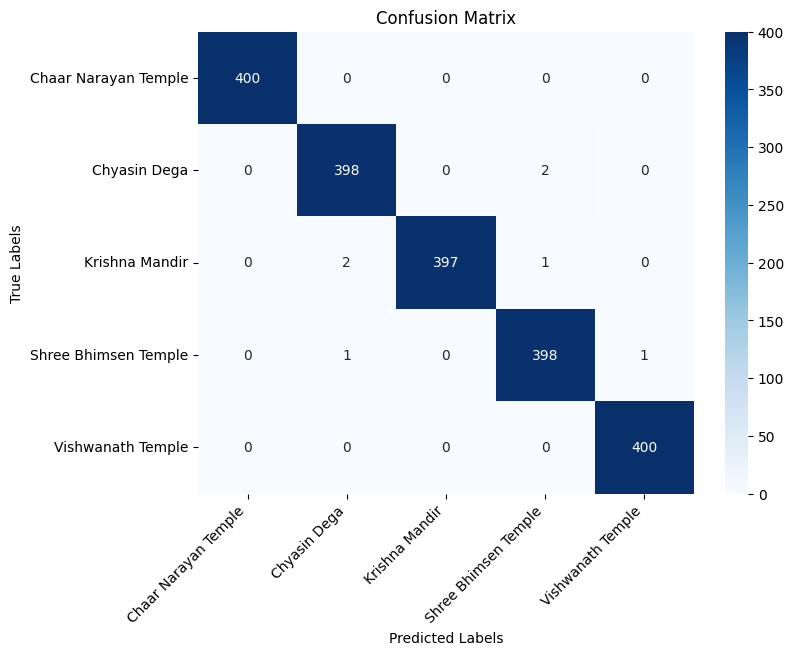

In [48]:
import cv2
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import load_model

#Applying Grayscale
def custom_preprocessing5(image):
    image = cv2.resize(image, (img_size, img_size))
    
    return image.astype('float32')

# Load the pre-trained model
model_path = r'C:\Users\Acer\Desktop\Minor Project\mlTrain_gpu-V3.h5'
model = load_model(model_path)

# Set the path to your test dataset
test_data_dir = r'C:\Users\Acer\Desktop\Minor Project\Dataset'
img_width, img_height = 64, 64 
batch_size = 32

# Data Preprocessing for testing set
test_datagen = ImageDataGenerator(rescale=1./255,preprocessing_function=custom_preprocessing5)

test_generator = test_datagen.flow_from_directory(test_data_dir,
                                                  target_size=(img_width, img_height),
                                                  batch_size=batch_size,
                                                  class_mode='categorical',
                                                  shuffle=False)  # Ensure labels are in the same order as predictions

# Get true labels
true_labels = test_generator.classes

# Make predictions
predictions = model.predict(test_generator)

# Get predicted labels
predicted_labels = np.argmax(predictions, axis=1)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Calculate Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Display F1 score
print(f"F1 Score: {f1:.4f}")

# Display Confusion Matrix with rotated x-axis labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices, cbar=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.xticks(rotation=45, ha="right")  # Rotate x-axis labels
plt.show()
